In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

In [ ]:
# Step 2: Load a pretrained YOLOv8 model
model_board = YOLO("yolo11n.pt")  

# Step 4: Train the model
model_board.train(
    data="board_config.yml",
    epochs=10,
    batch=30,
    imgsz=480,
    device=0,
    pretrained=True,
    optimizer="auto",
    seed=0,
    deterministic=True,
    workers=8,
    project="runs/detect_board",
    name="train"
)

# Step 5: Validate and save the model_board
metrics = model_board.val(project="runs/detect_board", name="val")  # Run validation
model_board.save("runs/detect_board/train/weights/best.pt")  # Save trained model_board

# Step 6: Export the model_board
model_board.export(format="torchscript", project="runs/detect_board", name="export")  # Convert to TorchScript for deployment

# Step 7: Print performance metrics
print(metrics)

Ultralytics 8.3.75 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=board_config.yml, epochs=10, time=None, patience=100, batch=30, imgsz=480, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /home/ruben/DeepLearning/final_project/datasets/cornerx_detection/train/labels.cache... 3836 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3836/3836 [00:00<?, ?it/s]
val: Scanning /home/ruben/DeepLearning/final_project/datasets/cornerx_detection/valid/labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.7G      2.775      2.095      1.211       1267        480: 100%|██████████| 128/128 [01:50<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


                   all       1096      53703      0.622      0.566      0.553      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.62G      2.006      1.045     0.9135       1260        480: 100%|██████████| 128/128 [01:27<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


                   all       1096      53703      0.873      0.796      0.852      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.62G      1.919     0.9797     0.9006       1268        480: 100%|██████████| 128/128 [01:21<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


                   all       1096      53703      0.861      0.778      0.817      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.62G      1.855     0.9405     0.8897       1267        480: 100%|██████████| 128/128 [01:39<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


                   all       1096      53703      0.862      0.783      0.837      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.62G      1.791     0.9028     0.8803       1273        480: 100%|██████████| 128/128 [01:19<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


                   all       1096      53703      0.899      0.839      0.895      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.62G      1.669     0.8476     0.8666       1250        480: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


                   all       1096      53703      0.888      0.837      0.882      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.62G      1.604     0.8011     0.8566       1269        480: 100%|██████████| 128/128 [01:20<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


                   all       1096      53703      0.924      0.866       0.92      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.62G      1.522     0.7764       0.85       1270        480: 100%|██████████| 128/128 [01:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.27it/s]


                   all       1096      53703      0.935      0.889      0.933      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.62G      1.473     0.7354     0.8437       1264        480: 100%|██████████| 128/128 [01:15<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


                   all       1096      53703      0.937      0.893      0.938      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.62G      1.391     0.6941     0.8387       1270        480: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


                   all       1096      53703      0.954      0.909      0.952      0.574

10 epochs completed in 0.320 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.4MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:53<00:00,  2.82s/it]


                   all       1096      53703      0.954      0.909      0.952      0.574
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train4
Ultralytics 8.3.75 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/ruben/DeepLearning/final_project/datasets/cornerx_detection/valid/labels.cache... 1096 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1096/1096 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.51s/it]


                   all       1096      53703      0.953      0.909      0.952      0.576
Speed: 0.7ms preprocess, 9.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train42


RuntimeError: Parent directory runs/detect_board/train does not exist.

In [ ]:
# Step 2: Load a pretrained YOLOv8 model
model_pieces = YOLO("yolo11n.pt")  

# Step 4: Train the model_pieces
model_pieces.train(
    data="pieces_config.yml",
    epochs=10,
    batch=30,
    imgsz=480,
    device=0,
    pretrained=True,
    optimizer="auto",
    seed=0,
    deterministic=True,
    workers=8,
    project="runs/detect_pieces",
    name="train"
)

# Step 5: Validate and save the model_pieces
metrics = model_pieces.val(project="runs/detect_pieces", name="val")  # Run validation
model_pieces.save("runs/detect_pieces/train/weights/best.pt")  # Save trained model_pieces

# Step 6: Export the model_pieces
model_pieces.export(format="torchscript", project="runs/detect_pieces", name="export")  # Convert to TorchScript for deployment

# Step 7: Print performance metrics
print(metrics)

Ultralytics 8.3.75 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=updated_config.yml, epochs=10, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /home/ruben/DeepLearning/final_project/datasets/train/labels.cache... 606 images, 0 backgrounds, 0 corrupt: 100%|██████████| 606/606 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/ruben/DeepLearning/final_project/datasets/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.0fe973299ff9e73874d9e684cba4e406.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/ruben/DeepLearning/final_project/datasets/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.5e1a9d49ad09f5a7549225a05e1f66a6.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/ruben/DeepLearning/final_project/datasets/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.bb226be189ee3a6399fbbd5080852e5b.jpg: 1 duplicate labels removed



val: Scanning /home/ruben/DeepLearning/final_project/datasets/valid/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.56G      1.646      4.131      1.211        143        480: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         58        386      0.026      0.728       0.15     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.59G      1.332       2.83      1.024         72        480: 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         58        386      0.977      0.069      0.332      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.57G      1.258      1.938      1.013         92        480: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         58        386      0.512      0.458      0.531      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.63G      1.245      1.509      1.012        105        480: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         58        386       0.53      0.656      0.651      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.57G      1.169      1.322     0.9852        237        480: 100%|██████████| 38/38 [00:13<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         58        386      0.684      0.705      0.793      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.58G      1.115      1.123     0.9832        143        480: 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         58        386      0.769      0.794      0.892      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.63G      1.097      1.058     0.9737        182        480: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         58        386      0.862      0.892      0.937      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.58G      1.058     0.9518     0.9664        156        480: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         58        386      0.875      0.911      0.968      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.59G      1.072     0.9081     0.9805        149        480: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         58        386      0.927      0.924      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.59G      1.022     0.8908     0.9535        131        480: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         58        386      0.945       0.93      0.975      0.751



10 epochs completed in 0.049 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.4MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


                   all         58        386      0.945       0.93      0.975      0.751
          black-bishop         13         22      0.993      0.818      0.949      0.682
            black-king         29         29      0.852      0.966      0.984      0.802
          black-knight         26         30      0.787          1      0.994      0.767
            black-pawn         25         77      0.986          1      0.995      0.773
           black-queen         11         11      0.995          1      0.995       0.72
            black-rook         24         28          1      0.936      0.981      0.733
          white-bishop         17         22      0.948      0.834      0.937      0.738
            white-king         29         29      0.879      0.966      0.981      0.753
          white-knight         17         19      0.894          1      0.974      0.772
            white-pawn         26         77          1      0.996      0.995      0.793
           white-quee

val: Scanning /home/ruben/DeepLearning/final_project/datasets/valid/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all         58        386      0.945       0.93      0.975      0.751
          black-bishop         13         22      0.993      0.818      0.949      0.685
            black-king         29         29      0.853      0.966      0.984      0.802
          black-knight         26         30      0.787          1      0.994      0.768
            black-pawn         25         77      0.986          1      0.995       0.77
           black-queen         11         11      0.999          1      0.995      0.738
            black-rook         24         28          1      0.934      0.981      0.735
          white-bishop         17         22      0.948      0.833      0.937       0.73
            white-king         29         29       0.88      0.966      0.981      0.753
          white-knight         17         19      0.895          1      0.974      0.766
            white-pawn         26         77          1      0.995      0.995      0.791
           white-quee


0: 480x480 51 xcorners, 85.0ms
Speed: 5.7ms preprocess, 85.0ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 480)


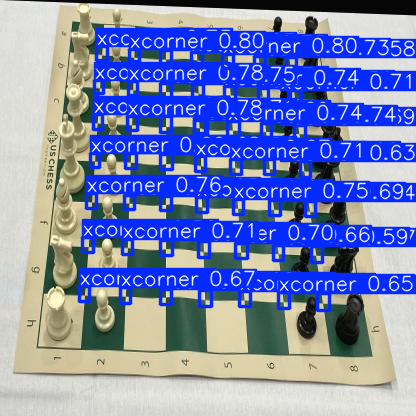

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the original image
image_path = "chessboard.jpg"
image = cv2.imread(image_path)
original_h, original_w = image.shape[:2]  # Get original image dimensions

# Load the trained board detection model
model_board = YOLO("runs/detect/train/weights/best.pt")

# Run inference (YOLO automatically resizes input)
results = model_board(image)[0]  # Get first result batch

results.show()

# Get YOLO's input size (from inference logs)
yolo_input_h, yolo_input_w = results.orig_shape

# Extract detected crossings and correctly map them to the original size
crossings = []
for box in results.boxes.data:
    x_min, y_min, x_max, y_max, conf, cls = box.cpu().numpy()

    # Compute the center of the detected crossing
    x_center = (x_min + x_max)/2
    y_center = (y_min + y_max)/2

    # **Map back to original image size**
    x_center = int(x_center * (original_w / yolo_input_w))  # Width scaling
    y_center = int(y_center * (original_h / yolo_input_h))  # Height scaling

    crossings.append((x_center, y_center))  # Save corrected points

# Convert to NumPy array
crossings = np.array(crossings)

# Sort crossings to structure them into an 8x8 grid
crossings = sorted(crossings, key=lambda p: (p[1], p[0]))  # Sort by y, then x


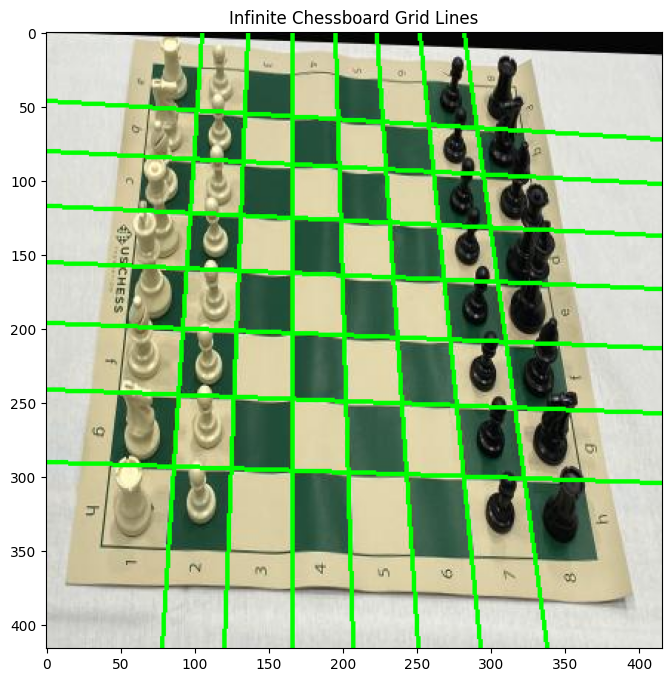

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

def complete_grid(crossings, image_shape):
    """
    Ensures we have a full 7x7 grid of crossings by estimating missing points.
    """
    # Sort points by Y, then X to structure into rows
    crossings = sorted(crossings, key=lambda p: (p[1], p[0]))

    # Try reshaping (if we have all points), otherwise estimate missing
    try:
        grid = np.array(crossings).reshape(7, 7, 2)
    except ValueError:
        print(f"Warning: Missing crossings detected. Trying to estimate...")

        # Convert to numpy array
        crossings = np.array(crossings)
        
        # Use k-means clustering to identify 7 rows
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(crossings[:, 1].reshape(-1, 1))
        row_labels = kmeans.labels_
        
        # Sort by row clusters
        sorted_crossings = []
        for i in range(7):
            row_points = crossings[row_labels == i]
            sorted_crossings.append(sorted(row_points, key=lambda p: p[0]))  # Sort by X in each row

        # Convert to structured grid (handling missing values)
        grid = np.full((7, 7, 2), np.nan)  # Initialize with NaNs
        for i, row in enumerate(sorted_crossings):
            for j, point in enumerate(row):
                if j < 7:
                    grid[i, j] = point  # Assign known points

        # Interpolate missing points (estimate based on neighbors)
        for i in range(7):
            for j in range(7):
                if np.isnan(grid[i, j]).any():
                    # Estimate missing point as average of neighbors
                    known_neighbors = []
                    if i > 0 and not np.isnan(grid[i-1, j]).any():
                        known_neighbors.append(grid[i-1, j])
                    if i < 6 and not np.isnan(grid[i+1, j]).any():
                        known_neighbors.append(grid[i+1, j])
                    if j > 0 and not np.isnan(grid[i, j-1]).any():
                        known_neighbors.append(grid[i, j-1])
                    if j < 6 and not np.isnan(grid[i, j+1]).any():
                        known_neighbors.append(grid[i, j+1])
                    
                    if known_neighbors:
                        grid[i, j] = np.mean(known_neighbors, axis=0)

    return grid

# Generate complete grid
grid = complete_grid(crossings, image.shape)


def compute_line_equation(p1, p2, img_shape):
    """
    Given two points, compute the infinite line equation and extend it to image boundaries.
    """
    x1, y1 = map(int, p1)
    x2, y2 = map(int, p2)
    
    if x1 == x2:  # Handle vertical lines
        return (x1, 0), (x1, img_shape[0] - 1)

    # Compute slope and intercept
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1

    # Compute intersections with image borders
    x_min, x_max = 0, img_shape[1] - 1
    y_min, y_max = 0, img_shape[0] - 1

    # Compute extended points
    y_xmin = int(slope * x_min + intercept)  # Left boundary
    y_xmax = int(slope * x_max + intercept)  # Right boundary

    x_ymin = int((y_min - intercept) / slope)  # Top boundary
    x_ymax = int((y_max - intercept) / slope)  # Bottom boundary

    # Clip to image bounds
    points = [
        (x_min, y_xmin),
        (x_max, y_xmax),
        (x_ymin, y_min),
        (x_ymax, y_max)
    ]
    
    # Keep only points within image bounds
    valid_points = [(int(x), int(y)) for x, y in points if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]]

    if len(valid_points) < 2:
        return (x1, y1), (x2, y2)  # If no valid extensions, return original points

    return valid_points[0], valid_points[-1]

def draw_infinite_grid(image, grid):
    """
    Draws the infinite extension of the chessboard grid.
    """
    img_h, img_w, _ = image.shape
    
    horizontal_lines = []
    vertical_lines = []

    # Extend and draw horizontal lines
    for row in grid:
        p1, p2 = row[0], row[-1]
        p1_ext, p2_ext = compute_line_equation(p1, p2, image.shape)
        horizontal_lines.append((p1_ext, p2_ext))
        cv2.line(image, p1_ext, p2_ext, (0, 255, 0), 2)

    # Extend and draw vertical lines
    for col in range(grid.shape[1]):
        p1, p2 = grid[0, col], grid[-1, col]
        p1_ext, p2_ext = compute_line_equation(p1, p2, image.shape)
        vertical_lines.append((p1_ext, p2_ext))
        cv2.line(image, p1_ext, p2_ext, (0, 255, 0), 2)

    return image, horizontal_lines, vertical_lines

# Draw infinite lines
image_with_infinite_grid, horizontal_lines, vertical_lines = draw_infinite_grid(image, grid)

# Display final image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_infinite_grid, cv2.COLOR_BGR2RGB))
plt.title("Infinite Chessboard Grid Lines")
plt.show()

In [94]:
horizontal_lines

[((0, 155), (415, 173)),
 ((0, 241), (415, 257)),
 ((0, 80), (415, 102)),
 ((0, 290), (415, 304)),
 ((0, 196), (415, 213)),
 ((0, 117), (415, 137)),
 ((0, 46), (415, 72))]

In [99]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load trained chess piece detection model
model_pieces = YOLO("runs/detect_pieces/train/best.pt")  

# Run inference for pieces
results_pieces = model_pieces(image)[0]

# Extract piece names dynamically
piece_names = model_pieces.model.names  

# Extract detected pieces
pieces = []
for box in results_pieces.boxes.data:
    x_min, y_min, x_max, y_max, conf, cls = box.cpu().numpy()
    piece_center = (int((x_min + x_max) // 2), int((y_min + y_max) // 2))  # Center of piece
    class_label = int(cls)  # Class ID
    piece_name = piece_names[class_label]  # Get name from YOLO model
    pieces.append((piece_center, piece_name))  # Save center and name

# **Use the extracted extended grid lines**
horizontal_lines, vertical_lines = draw_infinite_grid(image, grid)[1:]  # Extract only lines

# **Convert line segment points into sorted arrays**
horizontal_y_vals = np.array([line[0][1] for line in horizontal_lines])  # Take y1 from each line
vertical_x_vals = np.array([line[0][0] for line in vertical_lines])  # Take x1 from each line

horizontal_y_vals = np.sort(horizontal_y_vals)
vertical_x_vals = np.sort(vertical_x_vals)


print("Extracted Horizontal Lines Y-Coordinates:", horizontal_y_vals)
print("Extracted Vertical Lines X-Coordinates:", vertical_x_vals)

# **Create an 8x8 chessboard representation**
chessboard = np.full((8, 8), "", dtype=object)  

# **Assign each piece to a square with priority handling**
for piece_center, piece_name in pieces:
    x, y = piece_center

    # Find enclosing vertical lines
    left_idx = np.argmin(np.abs(vertical_x_vals - x))  # Closest vertical line


    right_idx = left_idx + 1 if left_idx + 1 < len(vertical_x_vals) else None

    # Find enclosing horizontal lines
    top_idx = np.argmin(np.abs(horizontal_y_vals - y))  # Closest horizontal line

    bottom_idx = top_idx + 1 if top_idx + 1 < len(horizontal_y_vals) else None

    # Determine the row and column based on line indices
    row = np.searchsorted(horizontal_y_vals, y, side="right") - 1
    col = np.searchsorted(vertical_x_vals, x, side="right") - 1


    # **Handle multiple pieces in one square: Give priority to non-rook**
    if row is not None and col is not None and row < 8 and col < 8:
        if chessboard[row, col] == "":  
            # If square is empty, place the piece
            chessboard[row, col] = piece_name
        else:
            # If a piece is already in the square, check if it's a rook
            existing_piece = chessboard[row, col]
            if "rook" in existing_piece.lower() and "rook" not in piece_name.lower():
                chessboard[row, col] = piece_name  # Replace only if it's a non-rook piece
    
    print(f"Piece: {piece_name} at {piece_center}")
    print(f"  → Closest Horizontal Line Y: {horizontal_y_vals[top_idx]}")
    print(f"  → Closest Vertical Line X: {vertical_x_vals[left_idx]}")
    print(f"  → Assigned to Square: ({top_idx}, {left_idx})")


# **Print 2D Chessboard Representation**
print("\nDetected Chessboard Positions:")
for row in chessboard:
    print(row)

# **Draw Chessboard Grid**
image_with_grid = image.copy()

for p1, p2 in horizontal_lines:
    cv2.line(image_with_grid, p1, p2, (0, 255, 0), 2)
for p1, p2 in vertical_lines:
    cv2.line(image_with_grid, p1, p2, (0, 255, 0), 2)

# **Overlay Text Labels for Squares**
for i in range(8):
    for j in range(8):
        piece = chessboard[i, j]
        if piece:
            square_center = (int((vertical_x_vals[j] + vertical_x_vals[j+1]) // 2), 
                             int((horizontal_y_vals[i] + horizontal_y_vals[i+1]) // 2))
            cv2.putText(image_with_grid, piece, square_center, cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (255, 0, 0), 2, cv2.LINE_AA)

# **Draw Center Points for Pieces**
for piece_center, _ in pieces:
    cv2.circle(image_with_grid, piece_center, 5, (0, 0, 255), -1)  # Small red dot

# **Display Image**
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_grid, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Piece Classification")
plt.show()



0: 480x480 1 black-king, 10 black-pawns, 2 black-rooks, 4 white-bishops, 1 white-knight, 8 white-pawns, 3 white-rooks, 117.6ms
Speed: 3.8ms preprocess, 117.6ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 480)
Extracted Horizontal Lines Y-Coordinates: [ 46  80 117 155 196 241 290]
Extracted Vertical Lines X-Coordinates: [105 136 166 195 223 252 282]
Piece: black-pawn at (282, 103)
  → Closest Horizontal Line Y: 117
  → Closest Vertical Line X: 282
  → Assigned to Square: (2, 6)
Piece: white-pawn at (117, 60)
  → Closest Horizontal Line Y: 46
  → Closest Vertical Line X: 105
  → Assigned to Square: (0, 0)
Piece: white-pawn at (113, 174)
  → Closest Horizontal Line Y: 155
  → Closest Vertical Line X: 105
  → Assigned to Square: (3, 0)
Piece: black-pawn at (276, 71)
  → Closest Horizontal Line Y: 80
  → Closest Vertical Line X: 282
  → Assigned to Square: (1, 6)
Piece: white-rook at (59, 316)
  → Closest Horizontal Line Y: 290
  → Closest Vertical Line X: 105
  → Assigned 

IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
import pandas as pd

# Convert the board to a readable format
df = pd.DataFrame(chessboard_representation, index=range(8, 0, -1), columns=list("abcdefgh"))

# Display the detected board
print(df)


# Other method

In [ ]:
break

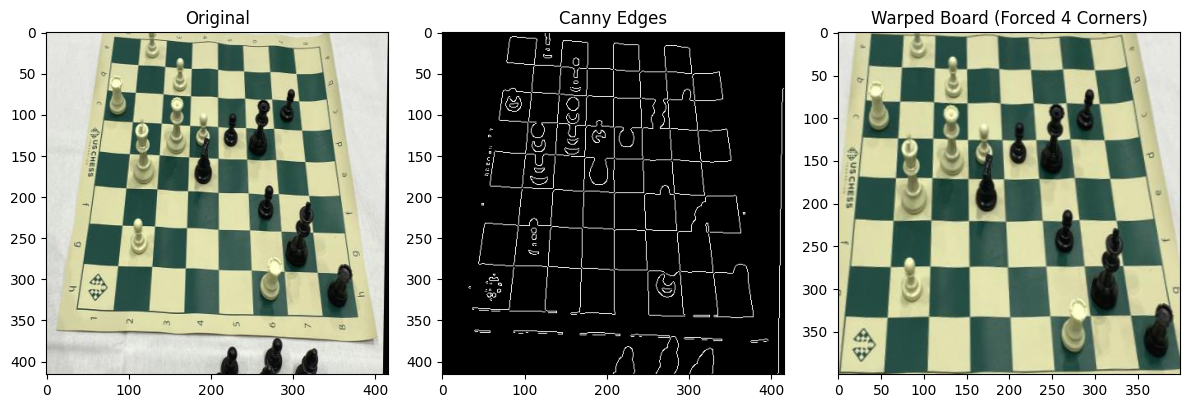

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Read image
image_path = "chessboard.jpg"
image = cv2.imread(image_path)  # BGR
original = image.copy()
gray   = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2) Threshold or Canny to get edges
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edges = cv2.Canny(binary, 50, 150)

# 3) (Optional) Some morphological operation if needed
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# 4) Find the largest contour - we assume that's the board
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    print("No contours found!")
    exit()

largest_contour = max(contours, key=cv2.contourArea)

# 5) Get a *rotated bounding box* around the largest contour
#    This will always return 4 corner points, even if the contour is incomplete.
rect = cv2.minAreaRect(largest_contour)
box  = cv2.boxPoints(rect)           # boxPoints returns 4 corner points
box  = np.int0(box)                  # convert to integer coords

# 6) Draw that bounding box for visualization
cv2.drawContours(original, [box], 0, (0, 255, 0), 3)

# 7) Reorder the 4 points (box) so they’re in [top-left, top-right, bottom-right, bottom-left] order.
#    A small helper function can do this:
def reorder_points(pts):
    """ Reorder corner points to a consistent order: tl, tr, br, bl """
    pts = sorted(pts, key=lambda x: x[0])  # sort by x
    leftmost = pts[:2]
    rightmost = pts[2:]
    
    leftmost = sorted(leftmost, key=lambda x: x[1])   # sort by y
    rightmost = sorted(rightmost, key=lambda x: x[1])
    
    tl, bl = leftmost
    tr, br = rightmost
    return np.array([tl, tr, br, bl], dtype="float32")

box_ordered = reorder_points(box)

# 8) Define a destination size, e.g. 400×400
dst_size = 400
dst_corners = np.array([
    [0, 0],
    [dst_size, 0],
    [dst_size, dst_size],
    [0, dst_size]
], dtype="float32")

# 9) Compute perspective transform and warp
M = cv2.getPerspectiveTransform(box_ordered, dst_corners)
warped = cv2.warpPerspective(image, M, (dst_size, dst_size))

# 10) Show results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.subplot(1,3,2), plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.subplot(1,3,3), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Warped Board (Forced 4 Corners)")
plt.tight_layout()
plt.show()


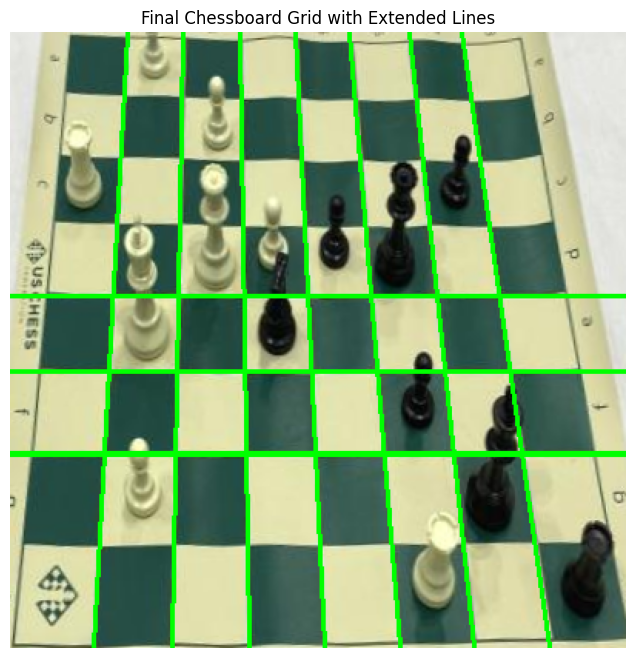

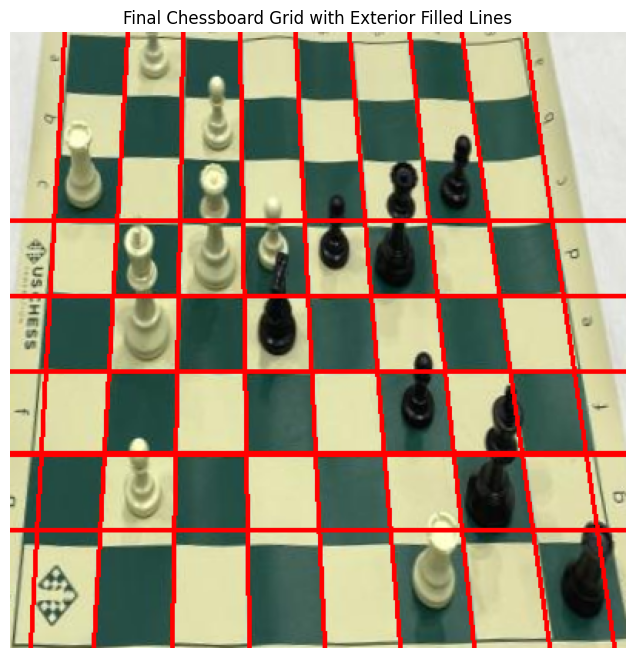

In [ ]:
from sklearn.cluster import KMeans
from itertools import combinations
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

def find_intersections(lines):
    """Finds all intersections between grid lines and keeps only those forming a chessboard structure."""
    intersections = []
    for (x1, y1, x2, y2), (x3, y3, x4, y4) in combinations(lines, 2):
        # Solve for intersection using matrix operations
        A = np.array([[x2 - x1, x3 - x4], [y2 - y1, y3 - y4]])
        b = np.array([x3 - x1, y3 - y1])
        
        if np.linalg.det(A) != 0:  # Ensure lines are not parallel
            t, s = np.linalg.solve(A, b)
            if 0 <= t <= 1 and 0 <= s <= 1:  # Only keep intersections within the segment
                px = int(x1 + t * (x2 - x1))
                py = int(y1 + t * (y2 - y1))
                intersections.append((px, py))

    return np.array(intersections)

def filter_grid_lines(lines, intersections, tolerance=10):
    """Filters grid lines by keeping only those that intersect at valid chessboard positions."""
    filtered_lines = []
    for x1, y1, x2, y2 in lines:
        count = sum(1 for px, py in intersections if min(x1, x2) - tolerance <= px <= max(x1, x2) + tolerance and 
                                                        min(y1, y2) - tolerance <= py <= max(y1, y2) + tolerance)
        if count >= 3:  # A valid chessboard line should have at least 3 intersections
            filtered_lines.append((x1, y1, x2, y2))

    return filtered_lines

def extend_line_to_bounds(line, img_shape):
    """
    Extends a given line (defined by endpoints) so that it spans the entire image.
    
    Parameters:
        line (tuple): (x1, y1, x2, y2) original line endpoints.
        img_shape (tuple): Shape of the image (height, width, channels).
        
    Returns:
        tuple: Two points (pt1, pt2) that are the intersections of the line with the image borders.
    """
    x1, y1, x2, y2 = line
    height, width = img_shape[:2]
    dx = x2 - x1
    dy = y2 - y1
    points = []
    
    # Check intersection with left (x=0) and right (x=width-1) borders if dx is nonzero
    if dx != 0:
        # Left border (x = 0)
        t = -x1 / dx
        y = y1 + t * dy
        if 0 <= y <= height - 1:
            points.append((0, int(round(y))))
        # Right border (x = width-1)
        t = (width - 1 - x1) / dx
        y = y1 + t * dy
        if 0 <= y <= height - 1:
            points.append((width - 1, int(round(y))))
    
    # Check intersection with top (y=0) and bottom (y=height-1) borders if dy is nonzero
    if dy != 0:
        # Top border (y = 0)
        t = -y1 / dy
        x = x1 + t * dx
        if 0 <= x <= width - 1:
            points.append((int(round(x)), 0))
        # Bottom border (y = height-1)
        t = (height - 1 - y1) / dy
        x = x1 + t * dx
        if 0 <= x <= width - 1:
            points.append((int(round(x)), height - 1))
    
    # Remove duplicate points
    unique_points = list(set(points))
    
    if len(unique_points) >= 2:
        # If more than 2 points, choose the two that are farthest apart
        if len(unique_points) > 2:
            max_dist = 0
            p1, p2 = unique_points[0], unique_points[1]
            for pt1 in unique_points:
                for pt2 in unique_points:
                    d = (pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2
                    if d > max_dist:
                        max_dist = d
                        p1, p2 = pt1, pt2
            return p1, p2
        else:
            return unique_points[0], unique_points[1]
    else:
        # Fallback: if no intersections with borders are found, return the original endpoints
        return (x1, y1), (x2, y2)

def detect_chess_grid(image_path):
    """Detects and filters valid chessboard grid lines."""
    
    # Load the image (assuming 'warped' is defined; otherwise load using cv2.imread)
    # For this example, we assume 'warped' is available.
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Detect edges using Canny
    edges = cv2.Canny(thresh, 50, 150, apertureSize=3)

    # Use Hough Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=80, maxLineGap=20)

    if lines is None:
        print("No lines detected.")
        return warped

    lines = [line[0] for line in lines]  # Flatten array

    # Find intersections
    intersections = find_intersections(lines)

    # Filter lines based on valid intersections
    filtered_lines = filter_grid_lines(lines, intersections)

    # Draw refined and extended grid lines
    img_lines = warped.copy()
    for line in filtered_lines:
        pt1, pt2 = extend_line_to_bounds(line, warped.shape)
        cv2.line(img_lines, pt1, pt2, (0, 255, 0), 2)

    # Display refined grid
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
    plt.title("Final Chessboard Grid with Extended Lines")
    plt.axis("off")
    plt.show()

    return filtered_lines

# Run the improved grid detection
grid_lines = detect_chess_grid(warped)

################################################################################
# ADDITIONAL CODE: Add exterior lines (without changing the original logic)
################################################################################

def separate_lines_by_orientation(lines):
    """
    Separates lines into quasi-vertical and quasi-horizontal groups.
    A line is considered quasi-vertical if its angle is within 15° of 90° (or -90°),
    and quasi-horizontal if its angle is within 15° of 0° (or 180°).
    """
    vertical, horizontal = [], []
    for line in lines:
        x1, y1, x2, y2 = line
        dx = x2 - x1
        dy = y2 - y1
        # Avoid division by zero; use arctan2 which handles dx=0.
        angle = np.degrees(np.arctan2(dy, dx))
        if abs(abs(angle) - 90) < 20:
            vertical.append(line)
        elif abs(angle) < 20 or abs(abs(angle) - 180) < 20:
            horizontal.append(line)
    return vertical, horizontal

def shift_line(line, delta, axis='vertical'):
    """
    Shifts a line by delta along the appropriate axis.
    For quasi-vertical lines, only the x-coordinates are shifted;
    for quasi-horizontal lines, only the y-coordinates are shifted.
    This preserves the inclination of the line.
    """
    x1, y1, x2, y2 = line
    if axis == 'vertical':
        return (x1 + delta, y1, x2 + delta, y2)
    elif axis == 'horizontal':
        return (x1, y1 + delta, x2, y2 + delta)
    else:
        return line

def fill_exterior_vertical_lines(v_lines, img_shape, expected_count=9):
    """
    Adds new quasi-vertical lines beyond the outermost existing lines.
    The expected distance between lines is computed from the existing lines.
    New lines are drawn by shifting the leftmost and rightmost lines by the expected spacing,
    while keeping their inclination.
    """
    height, width = img_shape[:2]
    if not v_lines:
        # If no vertical lines, create equally spaced vertical lines.
        xs = np.linspace(0, width-1, expected_count)
        return [(int(round(x)), 0, int(round(x)), height-1) for x in xs]

    # Compute average x positions
    xs = [(line[0]+line[2])/2 for line in v_lines]
    xs.sort()
    
    # Compute expected spacing using the median difference (or default spacing)
    if len(xs) > 1:
        spacings = [xs[i+1]-xs[i] for i in range(len(xs)-1)]
        expected_spacing = np.median(spacings)
    else:
        expected_spacing = width / (expected_count - 1)
    
    # Begin with the original lines (do not change them)
    filled = v_lines.copy()
    
    # Fill to the left (smaller x)
    leftmost = xs[0]
    current = leftmost
    while len(filled) < expected_count and current - expected_spacing >= 0:
        current -= expected_spacing
        # Find a line from v_lines that is the leftmost; use its inclination.
        ref_line = min(v_lines, key=lambda l: (l[0]+l[2])/2)
        new_line = shift_line(ref_line, -expected_spacing, axis='vertical')
        # Extend the new line to the image bounds.
        pt1, pt2 = extend_line_to_bounds(new_line, img_shape)
        filled.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    # Fill to the right (larger x)
    rightmost = xs[-1]
    current = rightmost
    while len(filled) < expected_count and current + expected_spacing <= width-1:
        current += expected_spacing
        ref_line = max(v_lines, key=lambda l: (l[0]+l[2])/2)
        new_line = shift_line(ref_line, expected_spacing, axis='vertical')
        pt1, pt2 = extend_line_to_bounds(new_line, img_shape)
        filled.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    # If more than expected_count, sort by average x and return the outermost expected_count.
    filled.sort(key=lambda l: (l[0]+l[2])/2)
    return filled[:expected_count]

def fill_exterior_horizontal_lines(h_lines, img_shape, expected_count=9):
    """
    Adds new quasi-horizontal lines beyond the outermost existing lines.
    The expected distance between lines is computed from the existing lines.
    New lines are drawn by shifting the topmost and bottommost lines by the expected spacing,
    while keeping their inclination.
    """
    height, width = img_shape[:2]
    if not h_lines:
        ys = np.linspace(0, height-1, expected_count)
        return [(0, int(round(y)), width-1, int(round(y))) for y in ys]
    
    ys = [(line[1]+line[3])/2 for line in h_lines]
    ys.sort()
    
    if len(ys) > 1:
        spacings = [ys[i+1]-ys[i] for i in range(len(ys)-1)]
        expected_spacing = np.median(spacings)
    else:
        expected_spacing = height / (expected_count - 1)
    
    filled = h_lines.copy()
    
    # Fill upward (smaller y)
    topmost = ys[0]
    current = topmost
    while len(filled) < expected_count and current - expected_spacing >= 0:
        current -= expected_spacing
        ref_line = min(h_lines, key=lambda l: (l[1]+l[3])/2)
        new_line = shift_line(ref_line, -expected_spacing, axis='horizontal')
        pt1, pt2 = extend_line_to_bounds(new_line, img_shape)
        filled.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    # Fill downward (larger y)
    bottommost = ys[-1]
    current = bottommost
    while len(filled) < expected_count and current + expected_spacing <= height-1:
        current += expected_spacing
        ref_line = max(h_lines, key=lambda l: (l[1]+l[3])/2)
        new_line = shift_line(ref_line, expected_spacing, axis='horizontal')
        pt1, pt2 = extend_line_to_bounds(new_line, img_shape)
        filled.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    filled.sort(key=lambda l: (l[1]+l[3])/2)
    return filled[:expected_count]

def add_exterior_lines(filtered_lines, img_shape, expected_count=9):
    """
    Using the existing extended lines (filtered_lines), add exterior lines so that there are
    exactly 'expected_count' quasi-vertical and 'expected_count' quasi-horizontal lines.
    The new lines are drawn using the inclination of the outmost lines and are shifted
    outward by the expected spacing.
    """
    # Separate the filtered (extended) lines into quasi-vertical and quasi-horizontal.
    vertical, horizontal = separate_lines_by_orientation(filtered_lines)
    
    # Fill exterior lines for each group.
    ext_vertical = fill_exterior_vertical_lines(vertical, img_shape, expected_count)
    ext_horizontal = fill_exterior_horizontal_lines(horizontal, img_shape, expected_count)
    
    return ext_vertical + ext_horizontal

# Get the exterior lines based on the previously detected (extended) grid_lines.
exterior_lines = add_exterior_lines(grid_lines, warped.shape, expected_count=9)
exterior_lines = add_exterior_lines(exterior_lines, warped.shape, expected_count=9)

# Draw both the original extended grid lines and the new exterior lines.
img_final = warped.copy()

# Draw original extended lines (in green)
for line in grid_lines:
    pt1, pt2 = extend_line_to_bounds(line, warped.shape)
    cv2.line(img_final, pt1, pt2, (0, 255, 0), 2)

# Draw new exterior lines (in red)
for line in exterior_lines:
    pt1, pt2 = extend_line_to_bounds(line, warped.shape)
    cv2.line(img_final, pt1, pt2, (0, 0, 255), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.title("Final Chessboard Grid with Exterior Filled Lines")
plt.axis("off")
plt.show()


In [ ]:
def get_corner_color(image_path, corner):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extract the pixel color at the given corner
    x, y = corner.ravel()
    color = gray[y, x]

    # Determine if it’s white or black (thresholding)
    return "white" if color > 127 else "black"

# Pick one corner and check its color
corner_color = get_corner_color("chessboard.jpg", corners[0])
print(f"Corner color: {corner_color}")


In [ ]:
def reorder_corners(corners):
    # Convert to a sorted array (top-left, top-right, bottom-left, bottom-right)
    corners = sorted(corners, key=lambda x: (x[0][1], x[0][0]))

    top_left, top_right = corners[:2]
    bottom_left, bottom_right = corners[2:]

    return np.array([top_left, top_right, bottom_left, bottom_right])

def ensure_correct_orientation(image_path, corners):
    # Sort the corners
    sorted_corners = reorder_corners(corners)

    # Check the color of the bottom-right square
    bottom_right_color = get_corner_color(image_path, sorted_corners[3])

    if bottom_right_color == "black":
        print("Rotating board to correct orientation...")
        return sorted_corners[::-1]  # Rotate 180 degrees
    else:
        print("Board orientation is correct.")
        return sorted_corners

# Ensure correct orientation
corrected_corners = ensure_correct_orientation("chessboard.jpg", corners)


In [ ]:
def align_chessboard(image_path, corners):
    img = cv2.imread(image_path)

    # Define the target chessboard size (standard 800x800 grid)
    dst_pts = np.float32([[0, 0], [800, 0], [800, 800], [0, 800]])

    # Get transformation matrix
    matrix = cv2.getPerspectiveTransform(np.float32(corners), dst_pts)

    # Apply the transformation
    aligned_board = cv2.warpPerspective(img, matrix, (800, 800))

    # Display aligned board
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(aligned_board, cv2.COLOR_BGR2RGB))
    plt.title("Aligned Chessboard")
    plt.show()

    return aligned_board

# Apply alignment
aligned_board = align_chessboard("chessboard.jpg", corrected_corners)


In [ ]:
def detect_chess_pieces(image_path, model_path="yolo11n.pt"):
    model = YOLO(model_path)  # Load YOLO model
    results = model(image_path)  # Run inference

    detections = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            detections.append((x1, y1, x2, y2, class_id, confidence))

    return detections

# Run YOLO on the aligned board
detections = detect_chess_pieces("aligned_chessboard.jpg")
print(detections)


In [ ]:
def map_detections_to_board(detections, board_size=800):
    cell_size = board_size // 8  # Each square size

    chessboard = [["" for _ in range(8)] for _ in range(8)]  # Empty board

    for x1, y1, x2, y2, class_id, confidence in detections:
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        row = cy // cell_size
        col = cx // cell_size

        chessboard[row][col] = class_id  # Store piece in board grid

    return chessboard

# Convert detections to 2D board
board = map_detections_to_board(detections)

# Print board
for row in board:
    print(row)


# medium ex

Found a rectangular board contour with area: 70724.5


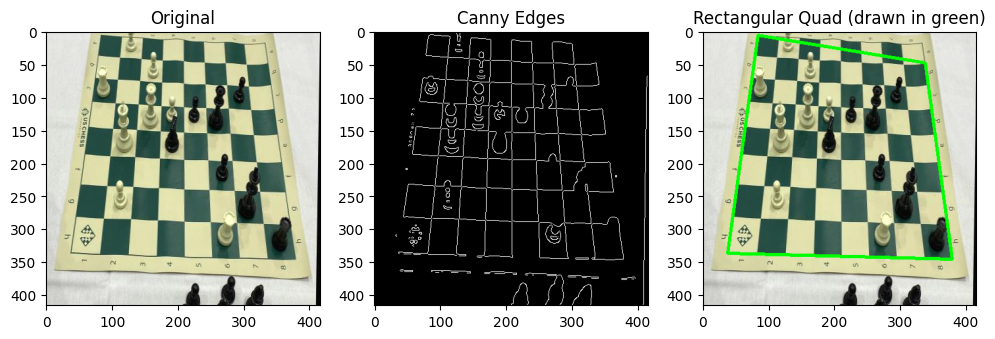

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Read image
image_path = "chessboard.jpg"
image = cv2.imread(image_path)  # BGR
original = image.copy()
gray   = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2) Threshold or Canny to get edges
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edges = cv2.Canny(binary, 50, 150)

# 3) (Optional) Some morphological operation if needed
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# 4) Find the largest contour - we assume that's the board
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    print("No contours found!")
    exit()

largest_contour = max(contours, key=cv2.contourArea)

# 5) Get a *rotated bounding box* around the largest contour
#    This will always return 4 corner points, even if the contour is incomplete.
rect = cv2.minAreaRect(largest_contour)
box  = cv2.boxPoints(rect)           # boxPoints returns 4 corner points
box  = np.int0(box)                  # convert to integer coords

# 6) Draw that bounding box for visualization
cv2.drawContours(original, [box], 0, (0, 255, 0), 3)

# 7) Reorder the 4 points (box) so they’re in [top-left, top-right, bottom-right, bottom-left] order.
#    A small helper function can do this:
def reorder_points(pts):
    """ Reorder corner points to a consistent order: tl, tr, br, bl """
    pts = sorted(pts, key=lambda x: x[0])  # sort by x
    leftmost = pts[:2]
    rightmost = pts[2:]
    
    leftmost = sorted(leftmost, key=lambda x: x[1])   # sort by y
    rightmost = sorted(rightmost, key=lambda x: x[1])
    
    tl, bl = leftmost
    tr, br = rightmost
    return np.array([tl, tr, br, bl], dtype="float32")

box_ordered = reorder_points(box)

# 8) Define a destination size, e.g. 400×400
dst_size = 400
dst_corners = np.array([
    [0, 0],
    [dst_size, 0],
    [dst_size, dst_size],
    [0, dst_size]
], dtype="float32")

# 9) Compute perspective transform and warp
M = cv2.getPerspectiveTransform(box_ordered, dst_corners)
warped = cv2.warpPerspective(image, M, (dst_size, dst_size))

# 10) Show results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.subplot(1,3,2), plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.subplot(1,3,3), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Warped Board (Forced 4 Corners)")
plt.tight_layout()
plt.show()


In [ ]:
sorted_coordinates = sorted(square_centers, key=lambda x: x[1], reverse=True)

groups = []
current_group = [sorted_coordinates[0]]

for coord in sorted_coordinates[1:]:
    if abs(coord[1] - current_group[-1][1]) < 50:
        current_group.append(coord)
    else:
        groups.append(current_group)
        current_group = [coord]

# Append the last group
groups.append(current_group)

# Step 2: Sort each group by the second index (column values)
for group in groups:
    group.sort(key=lambda x: x[0])

# Step 3: Combine the groups back together
sorted_coordinates = [coord for group in groups for coord in group]

sorted_coordinates[:10]


for num in range(len(sorted_coordinates)-1):
    if abs(sorted_coordinates[num][1] - sorted_coordinates[num+1][1])< 50 :
        if sorted_coordinates[num+1][0] - sorted_coordinates[num][0] > 150:
            x=(sorted_coordinates[num+1][0] + sorted_coordinates[num][0])/2
            y=(sorted_coordinates[num+1][1] + sorted_coordinates[num][1])/2
            p1=sorted_coordinates[num+1][5]
            p2=sorted_coordinates[num+1][4]
            p3=sorted_coordinates[num][3]
            p4=sorted_coordinates[num][2]
            sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])

IndexError: list index out of range

In [ ]:
square_num=1
for cor in sorted_coordinates:
  cv2.putText(img = board_squared,text = str(square_num),org = (int(cor[0])-30, int(cor[1])),
    fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 1,color = (125, 246, 55),thickness = 3)
  square_num+=1

plt.imshow(board_squared,cmap="gray")